When it comes to investing, comparing a fund's return to the S&P 500's return is often the best way to evaluate its performance. In this notebook, we will test out different machine learning techniques to see if we can predict, with a high degree of accuracy, whether or not a fund outperformed the S&P 500 from 2008 to 2018, a time period that included both a bull market and a bear market, and low and high commodity prices. While past performance does not guarantee future returns, it is safe to believe that over the long run, the value of most equity funds (ETFs and mutual funds with most of their assets in stocks) will appreciate. Therefore, if we can use machine learning to identify characteristics of these high performers, we may be able to use that data to predict whether or not a fund in the future will be able to outperform the S&P 500, something that could stand to make us a lot of money.

The dataset (which I found on Kaggle) was scraped from Yahoo Finance and can be found [here](https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs).

For a quick primer on what mutual funds and ETFs are, visit this [link](https://www.investopedia.com/articles/exchangetradedfunds/08/etf-mutual-fund-difference.asp).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

%matplotlib inline

We need to specify what each column's data type is. This will help us when we transform some of the columns.

In [2]:
col_types = {'net_assets':np.float64, 'fund_yield':np.float64,
       'net_annual_expense_ratio_fund':np.float64,'portfolio_stocks':np.float64,
       'price_earnings':np.float64, 'price_book':np.float64, 'price_sales':np.float64, 'price_cashflow':np.float64,
       'basic_materials':np.float64, 'consumer_cyclical':np.float64, 'financial_services':np.float64,
       'real_estate':np.float64, 'consumer_defensive':np.float64, 'healthcare':np.float64, 'utilities':np.float64,
       'communication_services':np.float64, 'energy':np.float64, 'industrials':np.float64, 'technology':np.float64, 
       'fund_beta_3years':np.float64, 'fund_beta_5years':np.float64, 'fund_beta_10years':np.float64,
       'fund_standard_deviation_3years':np.float64, 'fund_standard_deviation_5years':np.float64,
       'fund_standard_deviation_10years':np.float64, 'fund_return_10years':np.float64}

In [3]:
# read csv file and get number of rows in dataset
df_mf = pd.read_csv('mfdata.csv',dtype=col_types)
df_mf.shape[0]

25308

**Data Preparation/Cleaning**

Seeing as we're trying to compare mutual funds to the S&P 500, we can only look at stock/equity mutual funds. Looking at the data, we can see that non-equity funds tend to have missing data for the 'investment' column. We also only want to look at rows which don't have missing data. Since returns are rarely 0, we will assume that a value of zero for the 10-year return is in fact, a missing value.

Furthermore, we cannot consider any columns which are related to the return of the mutual fund, which means any rows with return data or any related metrics (Sharpe/Treynor ratio, alpha, fund $R^2$, etc.)

In [4]:
# only select mutual funds that have data for investment, are heavily invested in stocks, and aren't missing return data 
df_mf = df_mf[(df_mf['investment'] == 'Blend') | (df_mf['investment'] == 'Growth') | (df_mf['investment'] == 'Value')]
df_mf = df_mf[(df_mf['portfolio_stocks'] + df_mf['portfolio_cash']) > 95]
df_mf = df_mf[df_mf['portfolio_stocks'] > 80]
df_mf = df_mf[df_mf['fund_return_10years'] != 0]

In [5]:
# get list of columns that we want to consider
selected_columns = [
       'net_assets', 'fund_yield', 'investment', 'size',
       'net_annual_expense_ratio_fund','portfolio_stocks',
       'price_earnings', 'price_book', 'price_sales', 'price_cashflow',
       'basic_materials', 'consumer_cyclical', 'financial_services',
       'real_estate', 'consumer_defensive', 'healthcare', 'utilities',
       'communication_services', 'energy', 'industrials', 'technology', 'fund_beta_3years',
       'fund_beta_5years', 'fund_beta_10years',
       'fund_standard_deviation_3years', 'fund_standard_deviation_5years',
       'fund_standard_deviation_10years', 'fund_return_10years']

In [6]:
df_mf = df_mf[selected_columns]

In [7]:
# get number of rows in this subset
df_mf.shape[0]

8558

In [8]:
# number of rows with missing data
df_mf.shape[0] - df_mf.dropna().shape[0]

44

In [9]:
df_mf.dropna(inplace=True)

In [10]:
# number of rows with missing data after those rows have been dropped
df_mf.shape[0] - df_mf.dropna().shape[0]

0

In [11]:
# separate y values from features
s_rets = df_mf['fund_return_10years']
df_mf = df_mf.drop('fund_return_10years',axis=1)

In [12]:
# convert y values to binary variable for classification
# see the distribution of 1s and 0s to make sure it is not lopsided
# 13.6 is the 10 year (08-18) return of the S&P 500
s_rets = s_rets > 13.6
s_rets = s_rets.astype(int)
sum(s_rets)/len(s_rets)

0.5494479680526192

Looking at the data for net assets, we see that the range of values is from the low tens of millions to the trillions. Now, since we don't want this feature to single-handedly affect the outcome of our classification model, we need to transform the data in this column. Taking the log of the data makes the spread more reasonable, so we will do that.

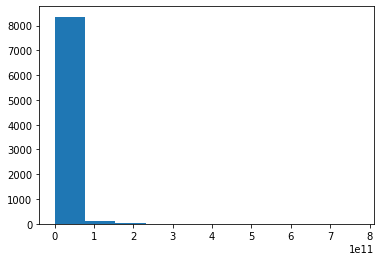

In [13]:
plt.hist(df_mf['net_assets'])
plt.show()

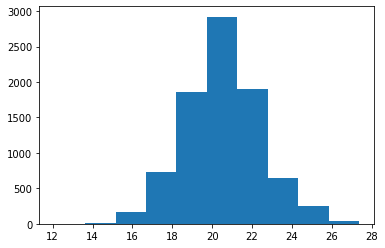

In [14]:
df_mf['net_assets'] = df_mf['net_assets'].apply(lambda x: math.log(x))

plt.hist(df_mf['net_assets'])
plt.show()

Since many machine learning models cannot handle categorical data, we need to convert data in those columns to numerical data, which we will do through one-hot encoding. 

In [15]:
investment_dummies = pd.get_dummies(df_mf['investment'],prefix="investment")
size_dummies = pd.get_dummies(df_mf['size'],prefix="size")

df_mf = pd.concat([df_mf,investment_dummies,size_dummies], axis=1)
df_mf = df_mf.drop(['investment','size'],axis=1)

df_mf.head()

,net_assets,fund_yield,net_annual_expense_ratio_fund,portfolio_stocks,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,...,fund_beta_10years,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years,investment_Blend,investment_Growth,investment_Value,size_Large,size_Medium,size_Small
2,20.800227,0.0,1.15,97.06,24.49,5.78,4.45,14.29,0.00,20.20,...,1.11,13.36,13.40,14.89,0,1,0,1,0,0
24,18.265780,1.0,1.79,99.99,12.29,1.61,0.85,10.20,7.56,29.10,...,1.01,13.76,17.00,20.17,1,0,0,1,0,0
26,20.163775,1.0,0.86,95.43,12.69,1.53,0.92,5.03,4.37,15.77,...,1.21,14.53,14.40,16.23,0,0,1,0,1,0
30,16.064695,0.0,1.95,89.52,26.07,3.46,2.06,16.87,5.56,12.50,...,1.06,12.94,12.14,17.56,0,1,0,0,1,0
35,22.481124,2.0,0.62,94.77,12.54,1.76,1.23,3.69,3.67,10.58,...,1.09,12.88,13.06,14.31,0,0,1,1,0,0


Now we will split the dataset into a training and test set. We will use the former to train the model, and the latter to evaluate its performance.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_mf, s_rets, test_size=0.20, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Since each column has different units, we need to scale the data in each column to a value between 0 and 1. To avoid the curse of dimensionality, we need to perform PCA on our feature space to transform our large dataset into a smaller one (referring to the number of columns here) that still captures most of the information in the larger one.  

In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_test_scaled = scaler.transform(X_test.to_numpy())

pca = PCA(.95)

pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# print number of columns in old and new datasets
print(X_train_scaled.shape[1])
pca.n_components_

31


10

**Model Training and Testing**

In this next section, we will test out 6 different models.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

**K-Nearest Neighbors Algorithm**

In [35]:
knn_clf = KNeighborsClassifier()
knn_params = {'n_neighbors' : list(range(3,52,2))}

knn_gridsearch = GridSearchCV(knn_clf,knn_params,cv=5,scoring='accuracy', n_jobs=-1)
knn_gridsearch.fit(X_train_pca,y_train.to_numpy())

print("Best params:",knn_gridsearch.best_params_)
best_knn = knn_gridsearch.best_estimator_

knn_accuracy = cross_val_score(best_knn,X_train_pca, y_train.to_numpy(), cv=5, scoring='accuracy', n_jobs=-1)
print('Average train accuracy:', round(sum(knn_accuracy)/len(knn_accuracy)*100,3))

knn_preds = best_knn.predict(X_test_pca)

Best params: {'n_neighbors': 3}
Average train accuracy: 89.796


In [36]:
print(confusion_matrix(y_test.to_numpy(), knn_preds))
print(classification_report(y_test.to_numpy(), knn_preds))

[[659 106]
 [ 61 877]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       765
           1       0.89      0.93      0.91       938

    accuracy                           0.90      1703
   macro avg       0.90      0.90      0.90      1703
weighted avg       0.90      0.90      0.90      1703



**Support Vector Machine**

In [37]:
svm_clf = SVC()
svm_params = {
    'C':[0.1,0.5,1,5,10,50,100],
    'gamma':['scale','auto'],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[1,2,3,4,5]
}

svm_gridsearch = GridSearchCV(svm_clf, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_gridsearch.fit(X_train_pca, y_train.to_numpy())

print("Best params:",svm_gridsearch.best_params_)
best_svm = svm_gridsearch.best_estimator_

svm_accuracy = cross_val_score(best_svm, X_train_pca, y_train.to_numpy(), cv=5, scoring = 'accuracy', n_jobs=-1)
print('Average train accuracy:',round(sum(svm_accuracy)/len(svm_accuracy)*100,3))

svm_preds = best_svm.predict(X_test_pca)

Best params: {'C': 100, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
Average train accuracy: 85.288


In [38]:
print(confusion_matrix(y_test.to_numpy(), svm_preds))
print(classification_report(y_test.to_numpy(), svm_preds))

[[601 164]
 [116 822]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       765
           1       0.83      0.88      0.85       938

    accuracy                           0.84      1703
   macro avg       0.84      0.83      0.83      1703
weighted avg       0.84      0.84      0.83      1703



**Logistic Regression**

In [41]:
lr_clf = LogisticRegression(random_state=42)
lr_params = {
    'C':[0.1,0.5,1,5,10,50,100],
    'penalty':['l2'],
    'solver':['liblinear', 'sag', 'lbfgs', 'newton-cg']
}

lr_gridsearch = GridSearchCV(lr_clf, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_gridsearch.fit(X_train_pca, y_train.to_numpy())

print("Best params:",lr_gridsearch.best_params_)
best_lr = lr_gridsearch.best_estimator_

lr_accuracy = cross_val_score(best_lr, X_train_pca, y_train.to_numpy(), cv=5, scoring = 'accuracy', n_jobs=-1)
print('Average train accuracy:',round(sum(lr_accuracy)/len(lr_accuracy)*100,3))

lr_preds = best_lr.predict(X_test_pca)

Best params: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}
Average train accuracy: 80.619


In [42]:
print(confusion_matrix(y_test.to_numpy(), lr_preds))
print(classification_report(y_test.to_numpy(), lr_preds))

[[554 211]
 [160 778]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       765
           1       0.79      0.83      0.81       938

    accuracy                           0.78      1703
   macro avg       0.78      0.78      0.78      1703
weighted avg       0.78      0.78      0.78      1703



**Decision Tree Classifier**

In [44]:
dtc_clf = DecisionTreeClassifier(random_state=42)
dtc_params = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[5,10,15,20],
    'max_features':['log2', 'sqrt'],
    'min_samples_leaf':[5,10,15]
}

dtc_gridsearch = GridSearchCV(dtc_clf, dtc_params, cv=5, scoring='accuracy', n_jobs=-1)
dtc_gridsearch.fit(X_train_pca, y_train.to_numpy())

print("Best params:",dtc_gridsearch.best_params_)
best_dtc = dtc_gridsearch.best_estimator_

dtc_accuracy = cross_val_score(best_dtc, X_train_pca, y_train.to_numpy(), cv=5, scoring = 'accuracy', n_jobs=-1)
print('Average train accuracy:',round(sum(dtc_accuracy)/len(dtc_accuracy)*100,3))

dtc_preds = best_dtc.predict(X_test_pca)

Best params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'splitter': 'best'}
Average train accuracy: 88.665


In [45]:
print(confusion_matrix(y_test.to_numpy(), dtc_preds))
print(classification_report(y_test.to_numpy(), dtc_preds))

[[656 109]
 [ 78 860]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       765
           1       0.89      0.92      0.90       938

    accuracy                           0.89      1703
   macro avg       0.89      0.89      0.89      1703
weighted avg       0.89      0.89      0.89      1703



**AdaBoost Classifier**

In [46]:
adb_clf = AdaBoostClassifier(random_state=42)
adb_params = {'n_estimators':[50,100,200,300,500]}

adb_gridsearch = GridSearchCV(adb_clf, adb_params, cv=5, scoring='accuracy', n_jobs=-1)
adb_gridsearch.fit(X_train_pca, y_train.to_numpy())

print("Best params:",adb_gridsearch.best_params_)
best_adb = adb_gridsearch.best_estimator_

adb_accuracy = cross_val_score(best_adb, X_train_pca, y_train.to_numpy(), cv=5, scoring = 'accuracy', n_jobs=-1)
print('Average train accuracy:',round(sum(adb_accuracy)/len(adb_accuracy)*100,3))

adb_preds = best_adb.predict(X_test_pca)

Best params: {'n_estimators': 500}
Average train accuracy: 84.466


In [47]:
print(confusion_matrix(y_test.to_numpy(), adb_preds))
print(classification_report(y_test.to_numpy(), adb_preds))

[[598 167]
 [107 831]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       765
           1       0.83      0.89      0.86       938

    accuracy                           0.84      1703
   macro avg       0.84      0.83      0.84      1703
weighted avg       0.84      0.84      0.84      1703



**Random Forest Classifier**

In [50]:
rdf_clf = RandomForestClassifier(random_state=42)
rdf_params = {
    'n_estimators':[50,100,200],
    'criterion':['gini','entropy'],
    'max_depth':[5,10,15,20],
    'max_features':['log2', 'sqrt'],
    'min_samples_leaf':[5,10,15]
}


rdf_gridsearch = GridSearchCV(rdf_clf, rdf_params, cv=5, scoring='accuracy', n_jobs=-1)
rdf_gridsearch.fit(X_train_pca, y_train.to_numpy())

print("Best params:",rdf_gridsearch.best_params_)
best_rdf = rdf_gridsearch.best_estimator_

rdf_accuracy = cross_val_score(best_rdf, X_train_pca, y_train.to_numpy(), cv=5, scoring = 'accuracy', n_jobs=-1)
print('Average train accuracy:',round(sum(rdf_accuracy)/len(rdf_accuracy)*100,3))

rdf_preds = best_rdf.predict(X_test_pca)

Best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 200}
Average train accuracy: 90.647


In [51]:
print(confusion_matrix(y_test.to_numpy(), rdf_preds))
print(classification_report(y_test.to_numpy(), rdf_preds))

[[671  94]
 [ 57 881]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       765
           1       0.90      0.94      0.92       938

    accuracy                           0.91      1703
   macro avg       0.91      0.91      0.91      1703
weighted avg       0.91      0.91      0.91      1703



**Model Evaluation**

After testing out the 6 different models, the results show that the RandomForest model is the best. It has the highest accuracy for both the train and test set, and it seems to avoid overfitting. 

**Test Model on ETF data**

One last thing we should do is test our best model on ETF data. ETFs are similar to mutual funds, but still differ in their trading mechanism, liquidity, and management approach. Therefore, we expect ETFs and mutual funds that have similar characteristics to have similar returns, which in turn, should not affect our model's performance too much. That being said, it is reasonable to assume that the model's performance will not be as good as its performance on the mutual fund data.

In [52]:
# read data and get number of rows
df_etfs = pd.read_csv('ETFs.csv',dtype=col_types)
df_etfs.shape[0]

2352

In [53]:
# get rows that contain equity heavy funds with data for the investment column
df_etfs = df_etfs[(df_etfs['investment'] == 'Blend') | (df_etfs['investment'] == 'Growth') | (df_etfs['investment'] == 'Value')]
df_etfs = df_etfs[df_etfs['portfolio_stocks'] > 90]
df_etfs = df_etfs[df_etfs['fund_return_10years'] != 0]

In [54]:
# only get data for certain columns
df_etfs = df_etfs[selected_columns]

In [55]:
# get number of rows in subset
df_etfs.shape[0]

505

In [56]:
# number of rows with missing data
# since this number is a small fraction of the total number of rows,
# we can just drop these rows from the dataset
df_etfs.shape[0] - df_etfs.dropna().shape[0]

5

In [57]:
df_etfs.dropna(inplace=True)

In [58]:
# separate dependent variables from features
s_rets_etf = df_etfs['fund_return_10years']
df_etfs = df_etfs.drop('fund_return_10years',axis=1)

In [59]:
# get class labels and see how balanced the distribition of labels is
s_rets_etf = s_rets_etf > 13.6
s_rets_etf = s_rets_etf.astype(int)
sum(s_rets_etf)/len(s_rets_etf)

0.446

Just as we transformed the net assets column for the mutual fund data, we must do the same to the ETF data.

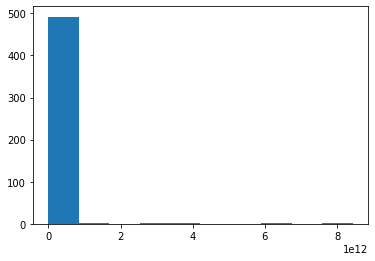

In [60]:
plt.hist(df_etfs['net_assets'])
plt.show()

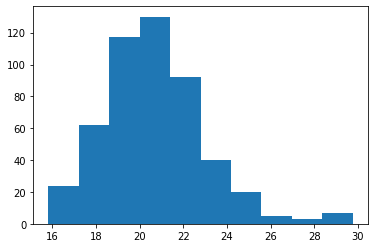

In [61]:
df_etfs['net_assets'] = df_etfs['net_assets'].apply(lambda x: math.log(x))

plt.hist(df_etfs['net_assets'])
plt.show()

Same goes for creating dummy variables for investment and size.

In [62]:
investment_dummies = pd.get_dummies(df_etfs['investment'],prefix="investment")
size_dummies = pd.get_dummies(df_etfs['size'],prefix="size")

df_etfs = pd.concat([df_etfs,investment_dummies,size_dummies], axis=1)
df_etfs = df_etfs.drop(['investment','size'],axis=1)
df_etfs.reset_index(inplace=True,drop=True)

df_etfs.head()

,net_assets,fund_yield,net_annual_expense_ratio_fund,portfolio_stocks,price_earnings,price_book,price_sales,price_cashflow,basic_materials,consumer_cyclical,...,fund_beta_10years,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years,investment_Blend,investment_Growth,investment_Value,size_Large,size_Medium,size_Small
0,29.019812,1.84,0.00,100.00,12.92,1.18,0.81,5.41,7.81,17.26,...,0.99,14.38,14.75,16.89,1,0,0,1,0,0
1,29.762818,1.77,0.05,99.99,12.92,1.18,0.81,5.41,7.81,17.26,...,0.98,14.38,14.75,16.83,1,0,0,1,0,0
2,28.947429,1.84,0.00,99.08,12.92,1.18,0.81,5.44,7.74,17.33,...,0.99,14.38,14.75,16.90,1,0,0,1,0,0
3,21.375591,2.57,0.00,100.00,11.34,1.12,1.07,4.06,2.41,14.25,...,1.06,15.16,16.21,18.39,1,0,0,1,0,0
4,21.904993,1.82,0.00,99.90,11.34,1.12,1.07,4.07,2.44,14.26,...,1.06,15.16,16.22,18.38,1,0,0,1,0,0


Apply the same scaler and PCA transformation to the ETF data

In [63]:
X_etfs_scaled = scaler.transform(df_etfs.to_numpy())
X_etfs_pca = pca.transform(X_etfs_scaled)

Use the Random Forest Classifier we trained and tested before to predict whether or not each ETF will outperform the S&P 500 over 10 years. Then compare the predictions to the actual outcomes and see how our model performed.

In [64]:
etf_acc = best_rdf.score(X_etfs_pca,s_rets_etf.to_numpy())
etf_acc

0.818

As you can see, there was a slight loss in performance, but not too severe. We can be assured that this model has some valid predictive power.